### A simple RANSAC algorithm demonstration to detect image overlay

- @KnightChaser
- Sep 10, 2025

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"OpenCV version: {cv2.__version__}")

OpenCV version: 4.11.0


In [30]:
def make_extractor() -> cv2.Feature2D:
    """
    Prefer SIFT (robust for text/edges), fall back to ORB/AKAZE if SIFT not available
    """
    if hasattr(cv2, 'SIFT_create'):
        return cv2.SIFT_create(nfeatures=6000)
    if hasattr(cv2, 'AKAZE_create'):
        return cv2.AKAZE_create()
    return cv2.ORB_create(nfeatures=6000)

def is_float_desc(desc: np.ndarray) -> bool:
    """
    Check if the descriptor is float32 (e.g. SIFT) or uint8 (e.g. ORB).
    """
    return desc is not None and desc.dtype == np.float32

def imread(path: Path) -> np.ndarray:
    """
    Read an image from a file.
    Raises FileNotFoundError if the image cannot be read.
    """
    img = cv2.imread(str(path))
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img

### Extract the image features

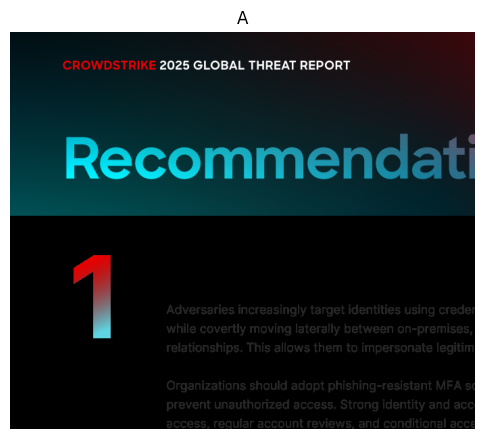

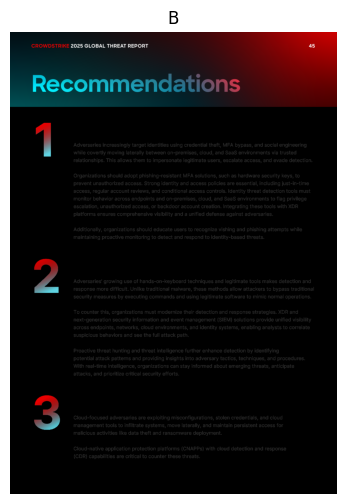

In [31]:
# NOTE: We don't know the relative pose between these two images
A_PATH = "./images/left_crop.png"
B_PATH = "./images/right_full.png"

A = imread(Path(A_PATH))
B = imread(Path(B_PATH))

def imshow(title: str, bgr: np.ndarray) -> None:
    """
    Show a BGR image using matplotlib (which expects RGB).
    """
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()


imshow("A", A)
imshow("B", B)

A: 1931 keypoints, desc shape: (1931, 128), float: True
B: 6007 keypoints, desc shape: (6007, 128), float: True


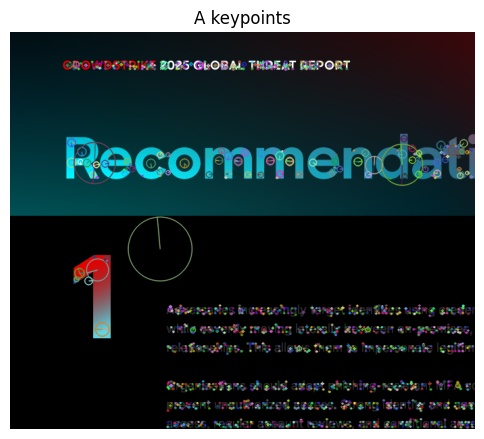

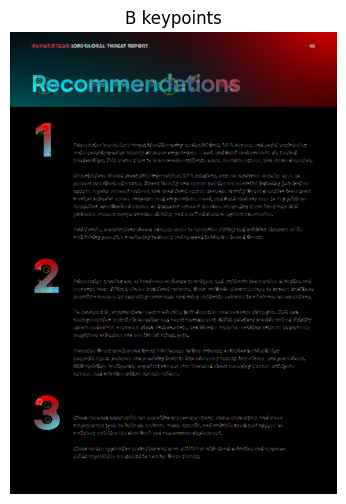

In [32]:
extractor = make_extractor()

def detect(gray: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Detect keypoints and compute descriptors.
    """
    # Finds keypoints and computes descriptors in one pass.
    keypoints, desc = extractor.detectAndCompute(gray, None)
    if desc is None or len(keypoints) < 10:
        raise ValueError("Not enough keypoints detected.")
    return keypoints, desc

A_gray = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)
B_gray = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)

# kp  = > list of cv2.KeyPoint, which has .pt (x,y), .size, .angle, ...
# desc => np.ndarray of shape (N_keypoints, descriptor_size), dtype=uint32 (for SIFT0)
A_kp, A_desc = detect(A_gray)
B_kp, B_desc = detect(B_gray)

print(f"A: {len(A_kp)} keypoints, desc shape: {A_desc.shape}, float: {is_float_desc(A_desc)}")
print(f"B: {len(B_kp)} keypoints, desc shape: {B_desc.shape}, float: {is_float_desc(B_desc)}")

# Visual check!
# Visualize the keypoints with size and orientation
A_vis = cv2.drawKeypoints(A, A_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
B_vis = cv2.drawKeypoints(B, B_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow("A keypoints", A_vis)
imshow("B keypoints", B_vis)    

In [33]:
def match_descriptors(q_desc: np.ndarray, s_desc: np.ndarray) -> list[list[cv2.DMatch]]:
    """
    Return list of [m, n] pairs, where m is the best match and n is the second best match,
    from knnMatch(k=2), or empty list if no matches found.

    Each cv2.DMatch has attributes:
    - queryIdx: index of the descriptor in the query set
    - trainIdx: index of the descriptor in the scene set
    - distance: distance between the descriptors (lower is better)
    - ...
    """
    if q_desc is None or s_desc is None:
        return []
    # Use a brute-force matcher with appropriate norm
    # - Use L2 norm for SIFT (float descriptors)
    # - Use Hamming norm for ORB/AKAZE (binary descriptors)
    matcher = cv2.BFMatcher(cv2.NORM_L2 if is_float_desc(q_desc) else cv2.NORM_HAMMING)
    raw_matches = matcher.knnMatch(q_desc, s_desc, k=2)
    return [pair for pair in raw_matches if len(pair) == 2]

# Example: matches for A -> B (query A, scene B)
raw_matches_AB = match_descriptors(A_desc, B_desc)
print(f"Found {len(raw_matches_AB)} raw matches between A and B")

Found 1931 raw matches between A and B


### RANSAC homography + diagnostics

In [34]:
def project_corners(q_img: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Project the corners of the query image using the homography H.
    (4 corners => [(0,0), (w,0), (w,h), (0,h)])
    Returns the projected corners as a (4,1,2) array.
    """
    h, w = q_img.shape[:2]
    corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    # Transforms points with homography.
    # To project the four corners of the query image into the scene.
    return cv2.perspectiveTransform(corners, H)  # shape (4,1,2)

def draw_quad(scene_bgr: np.ndarray, quad: np.ndarray, title: str = "Projected Quad") -> None:
    """
    Draw the projected quadrilateral on the scene image.
    """
    vis = scene_bgr.copy()
    quad_i = np.int32(quad.reshape(-1,2))
    cv2.polylines(vis, [quad_i], True, (0,255,0), 3, cv2.LINE_AA)
    imshow(title, vis)


In [35]:
def ransac_localize(q_kps: list[cv2.KeyPoint],
                    s_kps: list[cv2.KeyPoint],
                    raw_matches: list[list[cv2.DMatch]],
                    ratio: float = 0.75,
                    ransac_thresh: float = None,
                    min_inliers: int = 12) -> dict:
    """
    Perform RANSAC to find a homography between query and scene keypoints.
    1. Run a Lowe's ratio test to filter good matches.
    2. Run cv2.findHomography(..., RANSAC) to obtain H(3x3) and inlier mask.
    3. Count inliers and decide "ok" if H exists and there are enough inliers in the mask.
    4. Compute inlier_ratio for scoring.
    """
    # Lowe's ratio
    good = [m for m, n in raw_matches if m.distance < ratio * n.distance]
    if len(good) < 4:
        return dict(ok=False, reason="too_few_good_matches", good=good,
                    H=None, mask=None, inliners=0)

    if ransac_thresh is None:
        # Use a robust default based on the query keypoints if available
        if len(q_kps) > 0:
            ransac_thresh = max(3, 0.003 * max(q_kps[0].pt[0], q_kps[0].pt[1]))
        else:
            ransac_thresh = 3

    src = np.float32([q_kps[m.queryIdx].pt for m in good]).reshape(-1,2) # (N,2)
    dst = np.float32([s_kps[m.trainIdx].pt for m in good]).reshape(-1,2) # (N,2)
    # Estimates H (3x3 projective transform) mapping src => dst, using RANSAC.
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    if H is None:
        # No homography found
        return dict(ok=False, reason="no_homography", good=good,
                    H=None, mask=None, inliers=0)
    inliers = int(mask.ravel().sum())
    
    if inliers < min_inliers:
        # Too few inliers
        return dict(ok=False, reason="too_few_inliers", good=good,
                    H=H, mask=mask, inliers=inliers)
    
    return dict(ok=True, reason="success", good=good,
                H=H, mask=mask, inliers=inliers)

def try_direction(query_bgr: np.ndarray, 
                  scene_bgr: np.ndarray,
                  query_kp: list[cv2.KeyPoint], query_desc: np.ndarray,
                  scene_kp: list[cv2.KeyPoint], scene_desc: np.ndarray,
                  tag: str) -> dict:
    """
    Try to localize query in scene using RANSAC.
    Returns a dictionary with results.
    """
    raw_matches = match_descriptors(query_desc, scene_desc)
    res = ransac_localize(query_kp, scene_kp, raw_matches)
    res["tag"] = tag
    res["quad"] = project_corners(query_bgr, res["H"]) if res["ok"] else None

    # (Optional) also track ratio to compare scenes of different sizes:
    res["inlier_ratio"] = (res["inliers"] / max(1, len(res["good"])))
    return res

def draw_inliers(q_img: np.ndarray,
                 s_img: np.ndarray,
                 q_kps: list[cv2.KeyPoint],
                 s_kps: list[cv2.KeyPoint],
                 matches: list[cv2.DMatch],
                 mask: np.ndarray,
                 title: str = "Inlier Matches") -> None:
    """
    Draw inlier matches between query and scene images.
    """
    inlier_matches = [m for m, inlier in zip(matches, mask.ravel()) if inlier]
    vis = cv2.drawMatches(q_img, q_kps, s_img, s_kps, inlier_matches, None,
                          matchColor=(0,255,0), singlePointColor=(255,0,0),
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    imshow(title, vis)

In [36]:
def _score(res: dict) -> tuple[int, float]:
    """
    Robust scorer: prefer more inliers, tie-break by inlier ratio
    """
    return (res.get("inliers", 0), res.get("inlier_ratio", 0.0))

AB = try_direction(A, B, A_kp, A_desc, B_kp, B_desc, "A inside B")
BA = try_direction(B, A, B_kp, B_desc, A_kp, A_desc, "B inside A")

candidates = [r for r in (AB, BA) if r.get("ok")]

if candidates:
    best = max(candidates, key=_score)
    print(f"[✓] Inclusion detected: {best['tag']} | inliers={best['inliers']} ({best['inlier_ratio']:.2f} ratio)")
else:
    # graceful failure path
    best_failed = max((AB, BA), key=_score)
    print("No confident inclusion.")
    print("Best try:", best_failed["tag"],
          "| inliers:", best_failed.get("inliers", 0),
          "| reason:", best_failed.get("reason"))


[✓] Inclusion detected: B inside A | inliers=1105 (0.33 ratio)


### Check the overlay alignment by visualization

In [37]:
def warp_into_scene(query_bgr: np.ndarray, 
                    scene_bgr: np.ndarray, 
                    H: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Warp the query image into scene coordinates with H (query -> scene).
    Returns (warped_query_bgr, mask_bool) in scene size.
    """
    Hs, Ws = scene_bgr.shape[:2]
    warped = cv2.warpPerspective(query_bgr, H, (Ws, Hs))
    qmask = np.ones(query_bgr.shape[:2], dtype=np.uint8) * 255
    # Transforms an image by H (whole-image warp) into canvas size dsize=(W,H)
    mask = cv2.warpPerspective(qmask, H, (Ws, Hs)) > 0
    return warped, mask


def overlay_edges(scene_bgr: np.ndarray, 
                  warped_bgr: np.ndarray, 
                  mask: np.ndarray) -> np.ndarray:
    """
    Draw edges from the warped query (cyan) on top of the scene to highlight boundaries.
    """
    gray = cv2.cvtColor(warped_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160) # edge detection
    out = scene_bgr.copy()
    # only draw edges inside the valid warp area
    edge_locs = (edges > 0) & mask
    out[edge_locs] = (0, 255, 255)  # cyan
    return out

def diff_heatmap(scene_bgr: np.ndarray, 
                 warped_bgr: np.ndarray, 
                 mask: np.ndarray, 
                 alpha: float = 0.6) -> np.ndarray:
    """
    Show a heatmap of |scene - warped| inside the mask. Warmer = bigger mismatch.
    """
    diff = cv2.absdiff(scene_bgr, warped_bgr) # per-pixel absolute difference
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    norm = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heat = cv2.applyColorMap(norm, cv2.COLORMAP_JET)
    out = scene_bgr.copy()
    # cv2.addWeighted(A, α, B, β, γ) => α*A + β*B + γ
    out[mask] = cv2.addWeighted(scene_bgr[mask], 1 - alpha, heat[mask], alpha, 0)
    return out

def show_alignment(query_bgr: np.ndarray, 
                   scene_bgr: np.ndarray, 
                   H: np.ndarray, 
                   prefix: str) -> None:
    """
    Convenience: warp query->scene and show 3 complementary views.
    """
    warped, mask = warp_into_scene(query_bgr, scene_bgr, H)
    imshow(f"{prefix} · warped edges", overlay_edges(scene_bgr, warped, mask))
    imshow(f"{prefix} · diff heatmap", diff_heatmap(scene_bgr, warped, mask, alpha=0.55))


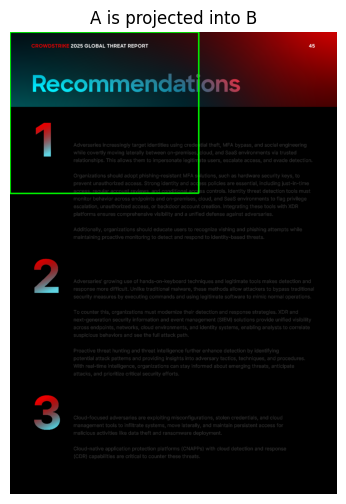

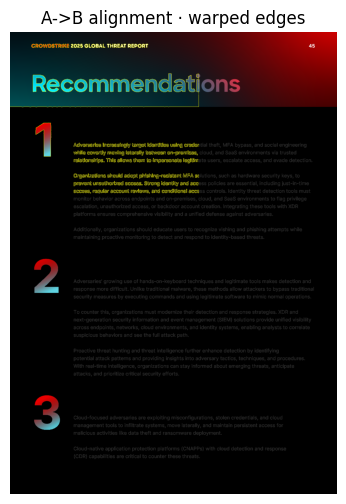

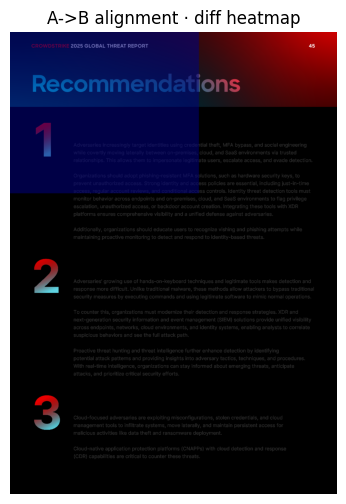

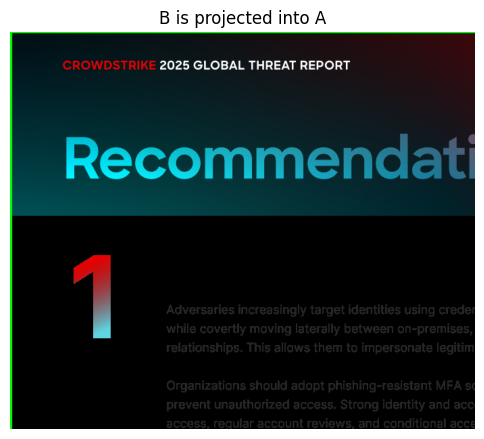

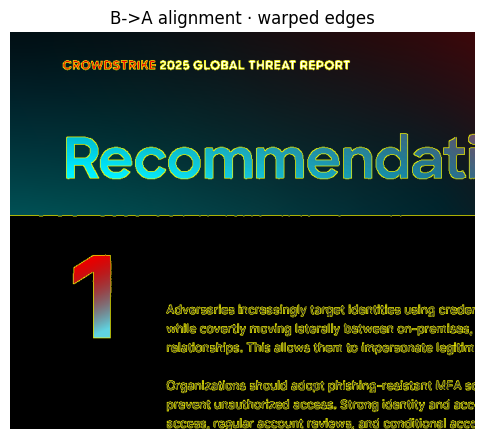

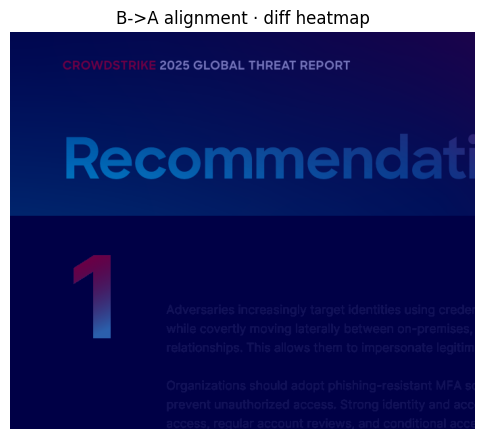

In [38]:
if candidates:
    if AB.get("ok"):
        draw_quad(B, project_corners(A, AB["H"]), title="A is projected into B")
        show_alignment(A, B, AB["H"], prefix="A->B alignment")
    if BA.get("ok"):
        draw_quad(A, project_corners(B, BA["H"]), title="B is projected into A")
        show_alignment(B, A, BA["H"], prefix="B->A alignment")